# Transfer learning / fine-tuning




In [61]:
#!pip install hyperas

In [1]:
%matplotlib inline

import os

#if using Theano with GPU
#os.environ["KERAS_BACKEND"] = "tensorflow"

import random
import numpy as np
import keras

import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation,GlobalAveragePooling2D
from keras.layers import Conv2D, MaxPooling2D
from keras.models import Model
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sns
import tensorflow as tf

In [2]:
import time

In [3]:
import numpy as np
from hyperopt import Trials, STATUS_OK, tpe
from keras.datasets import mnist
from keras.layers.core import Dense, Dropout, Activation
from keras.models import Sequential
from keras.utils import np_utils
from hyperas import optim
from hyperas.distributions import choice, uniform

## getting dataset.

In [65]:
!rm -r -f muestras muestras.zip
!wget -O muestras.zip https://gitlab.com/daquesada/tranfer-learning/-/raw/main/muestras_fix_c20.zip

--2022-04-11 16:51:11--  https://gitlab.com/daquesada/tranfer-learning/-/raw/main/muestras_fix_c20.zip
Resolving gitlab.com (gitlab.com)... 172.65.251.78, 2606:4700:90:0:f22e:fbec:5bed:a9b9
Connecting to gitlab.com (gitlab.com)|172.65.251.78|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 311859541 (297M) [application/zip]
Saving to: ‘muestras.zip’

muestras.zip        100%[===================>] 297.41M  65.0MB/s    in 4.6s    

2022-04-11 16:51:16 (65.1 MB/s) - ‘muestras.zip’ saved [311859541/311859541]



In [66]:
!unzip  muestras.zip

Archive:  muestras.zip
   creating: muestras/
   creating: muestras/test/
   creating: muestras/test/a16-AceiteMario/
  inflating: muestras/test/a16-AceiteMario/SingleShot0085.jpg  
  inflating: muestras/test/a16-AceiteMario/SingleShot0086.jpg  
  inflating: muestras/test/a16-AceiteMario/SingleShot0087.jpg  
  inflating: muestras/test/a16-AceiteMario/SingleShot0088.jpg  
  inflating: muestras/test/a16-AceiteMario/SingleShot0089.jpg  
  inflating: muestras/test/a16-AceiteMario/SingleShot0090.jpg  
  inflating: muestras/test/a16-AceiteMario/SingleShot0091.jpg  
  inflating: muestras/test/a16-AceiteMario/SingleShot0092.jpg  
  inflating: muestras/test/a16-AceiteMario/SingleShot0093.jpg  
  inflating: muestras/test/a16-AceiteMario/SingleShot0094.jpg  
  inflating: muestras/test/a16-AceiteMario/SingleShot0095.jpg  
  inflating: muestras/test/a16-AceiteMario/SingleShot0096.jpg  
  inflating: muestras/test/a16-AceiteMario/SingleShot0097.jpg  
  inflating: muestras/test/a16-AceiteMario/SingleS

# Utils

In [4]:
import tensorflow as tf
from tensorflow.keras import layers
resize_and_rescale = tf.keras.Sequential([layers.RandomFlip("vertical"),
  layers.RandomRotation(0.2),layers.RandomZoom(-1)])

2022-04-14 16:21:54.316966: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-14 16:21:54.328303: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-14 16:21:54.329015: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-14 16:21:54.330144: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [5]:
def crop_center(image):
  """Returns a cropped square image."""
  image = tf.image.central_crop(
    image, 0.5
  )
  return image

This function is useful for pre-processing the data into an image and input vector.

In [6]:
# helper function to load image and return it and input vector
def get_image(path):
    img = image.load_img(path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return img, x

load all data from root file

In [7]:
def load_data(categories):
  data = []
  for c, category in enumerate(categories):
      images = [os.path.join(dp, f) for dp, dn, filenames 
                in os.walk(category) for f in filenames 
                if os.path.splitext(f)[1].lower() in ['.jpg','.png','.jpeg']]
      for img_path in images:
          img, x = get_image(img_path)
          result_flip = resize_and_rescale(x[0])
          result_rot90 = tf.image.rot90(x[0])
          result_flip_left_right=tf.image.flip_left_right(x[0])
          result_flip_up_down=tf.image.flip_up_down(x[0])
          
          data.append({'x':np.array((x[0])), 'y':c})

          data.append({'x':np.array((result_flip)),'y':c})
          data.append({'x':np.array((result_rot90)), 'y':c})
          data.append({'x':np.array((result_flip_left_right)), 'y':c})
          data.append({'x':np.array((result_flip_up_down)), 'y':c})
          
  return data

In [8]:
def load_data_test(categories):
  data = []
  for c, category in enumerate(categories):
      images = [os.path.join(dp, f) for dp, dn, filenames 
                in os.walk(category) for f in filenames 
                if os.path.splitext(f)[1].lower() in ['.jpg','.png','.jpeg']]
      for img_path in images:
          img, x = get_image(img_path)          
          data.append({'x':np.array(x[0]), 'y':c})
          
  return data

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


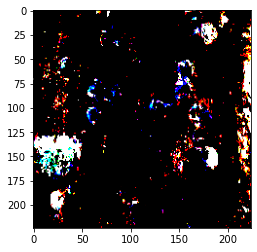

In [9]:
x,img=get_image("muestras/test/a16-AceiteMario/SingleShot0085.jpg")
result=resize_and_rescale(img[0])
plt.imshow(img[0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


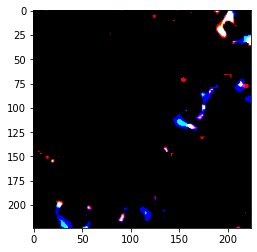

In [10]:
plt.imshow(result)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


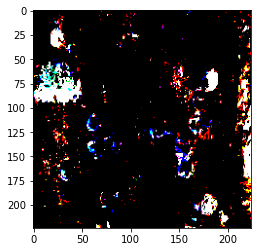

In [11]:
result_rot90 = tf.image.rot90(img[0])
result_flip_left_right=tf.image.flip_left_right(img[0])
result_flip_up_down=tf.image.flip_up_down(img[0])
plt.imshow(result_flip_up_down)

In [12]:
result == img[0]

<tf.Tensor: shape=(224, 224, 3), dtype=bool, numpy=
array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, Fa

# Extracción del conjunto de datos

In [13]:
root = 'muestras/train'
# exclude = ['BACKGROUND_Google', 'Motorbikes', 'airplanes', 'Faces_easy', 'Faces']

categories = [x[0] for x in os.walk(root) if x[0]][1:]
labels = [c.split("muestras/train/")[1] for c in categories]
categories = [c for c in categories]
# categories.pop(2)
print(categories)
print(labels)

['muestras/train/Urapan', 'muestras/train/Pino-patula', 'muestras/train/c715-tangare', 'muestras/train/Chanul', 'muestras/train/d575-caimito', 'muestras/train/n33-pomo', 'muestras/train/c717', 'muestras/train/Nogal-cafetero', 'muestras/train/Cipres', 'muestras/train/a16-AceiteMario', 'muestras/train/Cedro-costenio', 'muestras/train/Sajo', 'muestras/train/d543', 'muestras/train/a21-Palialte-Amarillo', 'muestras/train/Eucalipto-blanco', 'muestras/train/d574-cargadero', 'muestras/train/Guayacan-amarillo', 'muestras/train/Cuangare', 'muestras/train/aguamanil-c716', 'muestras/train/Achapo']
['Urapan', 'Pino-patula', 'c715-tangare', 'Chanul', 'd575-caimito', 'n33-pomo', 'c717', 'Nogal-cafetero', 'Cipres', 'a16-AceiteMario', 'Cedro-costenio', 'Sajo', 'd543', 'a21-Palialte-Amarillo', 'Eucalipto-blanco', 'd574-cargadero', 'Guayacan-amarillo', 'Cuangare', 'aguamanil-c716', 'Achapo']


In [14]:
data = load_data(categories)
# count the number of classes
num_classes = len(categories)
num_classes

20

In [15]:
root_test = 'muestras/test'
# exclude = ['BACKGROUND_Google', 'Motorbikes', 'airplanes', 'Faces_easy', 'Faces']
# train_split, val_split = 0.7, 0.15

categories_test = [x[0] for x in os.walk(root_test) if x[0]][1:]
labels_test = [c.split("muestras/test/")[1] for c in categories_test]
categories_test = [c for c in categories_test]
# categories.pop(2)
print(categories_test)
print(labels_test==labels)

['muestras/test/Urapan', 'muestras/test/Pino-patula', 'muestras/test/c715-tangare', 'muestras/test/Chanul', 'muestras/test/d575-caimito', 'muestras/test/n33-pomo', 'muestras/test/c717', 'muestras/test/Nogal-cafetero', 'muestras/test/Cipres', 'muestras/test/a16-AceiteMario', 'muestras/test/Cedro-costenio', 'muestras/test/Sajo', 'muestras/test/d543', 'muestras/test/a21-Palialte-Amarillo', 'muestras/test/Eucalipto-blanco', 'muestras/test/d574-cargadero', 'muestras/test/Guayacan-amarillo', 'muestras/test/Cuangare', 'muestras/test/aguamanil-c716', 'muestras/test/Achapo']
True


In [16]:
data_test = load_data_test(categories_test)
# count the number of classes
num_classes = len(categories)
num_classes

20

Randomize the data order.

In [17]:
random.shuffle(data)

In [18]:
random.shuffle(data_test)

create training / validation / test split (70%, 15%, 15%)

In [19]:
train_split, val_split = 0.7, 0.3

In [20]:
idx_val = int(train_split * len(data+data_test))
# idx_test = int((train_split + val_split) * len(data))
train = data[:idx_val]
val = data[idx_val:]
test = data_test
len(val),len(test),len(train)

(3151, 301, 8054)

Separate data for labels.

In [21]:
x_train, y_train = np.array([t["x"] for t in train]), [t["y"] for t in train]
x_val, y_val = np.array([t["x"] for t in val]), [t["y"] for t in val]
x_test, y_test = np.array([t["x"] for t in test]), [t["y"] for t in test]
print(y_test)

[16, 1, 8, 11, 9, 14, 4, 4, 14, 16, 17, 17, 8, 19, 8, 7, 9, 0, 7, 0, 2, 14, 15, 6, 18, 13, 4, 4, 7, 16, 11, 14, 17, 9, 19, 15, 8, 9, 7, 7, 19, 14, 5, 12, 3, 14, 11, 6, 15, 16, 12, 8, 10, 18, 13, 3, 3, 1, 17, 15, 15, 8, 18, 6, 9, 6, 12, 10, 15, 13, 10, 2, 4, 0, 5, 4, 10, 1, 19, 18, 3, 2, 8, 11, 0, 11, 1, 0, 16, 9, 6, 18, 3, 1, 14, 13, 10, 6, 17, 13, 7, 13, 13, 1, 12, 11, 19, 1, 19, 10, 11, 19, 16, 2, 13, 17, 12, 2, 9, 17, 5, 7, 7, 0, 5, 13, 1, 11, 2, 2, 15, 5, 0, 5, 10, 12, 1, 16, 18, 7, 15, 8, 7, 9, 10, 7, 3, 3, 11, 7, 18, 17, 3, 9, 8, 14, 12, 4, 1, 12, 3, 11, 14, 16, 17, 0, 4, 5, 7, 17, 4, 3, 9, 0, 4, 15, 8, 5, 3, 6, 16, 5, 12, 14, 12, 8, 18, 0, 7, 6, 10, 18, 13, 15, 18, 2, 8, 2, 1, 17, 0, 9, 5, 15, 8, 0, 11, 10, 4, 19, 12, 19, 10, 2, 18, 11, 2, 3, 18, 6, 6, 19, 0, 15, 19, 17, 0, 8, 5, 16, 11, 11, 3, 17, 6, 18, 16, 10, 9, 6, 9, 14, 12, 16, 5, 12, 19, 13, 19, 13, 8, 1, 4, 0, 13, 14, 11, 15, 14, 10, 6, 17, 17, 15, 5, 18, 12, 3, 16, 18, 13, 9, 4, 4, 10, 1, 9, 12, 13, 2, 17, 16, 6, 5, 6, 

Pre-process the data as before by making sure it's float32 and normalized between 0 and 1.

In [22]:
# normalize data
x_train = x_train.astype('float32') / 255.
x_val = x_val.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

# convert labels to one-hot vectors
y_train = keras.utils.np_utils.to_categorical(y_train, num_classes)
y_val = keras.utils.np_utils.to_categorical(y_val, num_classes)
y_test = keras.utils.np_utils.to_categorical(y_test, num_classes)
print(y_test.shape)

(301, 20)


In [23]:
def data_definition():
  return x_train, y_train, x_test, y_test

Let's get a summary of what we have.

In [24]:
# summary
print("finished loading %d images from %d categories"%(len(data+data_test), num_classes))
print("train / validation / test split: %d, %d, %d"%(len(x_train), len(x_val), len(x_test)))
print("training data shape: ", x_train.shape)
print("training labels shape: ", y_train.shape)


finished loading 11506 images from 20 categories
train / validation / test split: 8054, 3151, 301
training data shape:  (8054, 224, 224, 3)
training labels shape:  (8054, 20)


If everything worked properly, you should have loaded a bunch of images, and split them into three sets: `train`, `val`, and `test`. The shape of the training data should be (`n`, 224, 224, 3) where `n` is the size of your training set, and the labels should be (`n`, `c`) where `c` is the number of classes (97 in the case of `101_ObjectCategories`. 

Notice that we divided all the data into three subsets -- a training set `train`, a validation set `val`, and a test set `test`. The reason for this is to properly evaluate the accuracy of our classifier. During training, the optimizer uses the validation set to evaluate its internal performance, in order to determine the gradient without overfitting to the training set. The `test` set is always held out from the training algorithm, and is only used at the end to evaluate the final accuracy of our model.

Let's quickly look at a few sample images from our dataset.

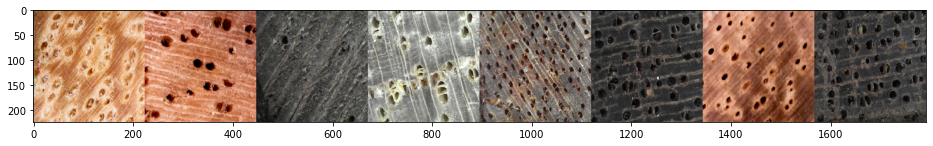

In [25]:
images = [os.path.join(dp, f) for dp, dn, filenames in os.walk(root) for f in filenames if os.path.splitext(f)[1].lower() in ['.jpg','.png','.jpeg']]
idx = [int(len(images) * random.random()) for i in range(8)]
imgs = [image.load_img(images[i], target_size=(224, 224)) for i in idx]
concat_image = np.concatenate([np.asarray(img) for img in imgs], axis=1)
plt.figure(figsize=(16,4))
plt.imshow(concat_image)

# First training a neural net from scratch

Before doing the transfer learning, let's first build a neural network from scratch for doing classification on our dataset. This will give us a baseline to compare to our transfer-learned network later.

The network we will construct contains 4 alternating convolutional and max-pooling layers, followed by a [dropout](https://www.cs.toronto.edu/~hinton/absps/JMLRdropout.pdf) after every other conv/pooling pair. After the last pooling layer, we will attach a fully-connected layer with 256 neurons, another dropout layer, then finally a softmax classification layer for our classes.

Our loss function will be, as usual, categorical cross-entropy loss, and our learning algorithm will be [AdaDelta](https://arxiv.org/abs/1212.5701). Various things about this network can be changed to get better performance, perhaps using a larger network or a different optimizer will help, but for the purposes of this notebook, the goal is to just get an understanding of an approximate baseline for comparison's sake, and so it isn't neccessary to spend much time trying to optimize this network.

Upon compiling the network, let's run `model.summary()` to get a snapshot of its layers.

In [ ]:
# build the network
model = Sequential()
print("Input dimensions: ",x_train.shape[1:])

model.add(Conv2D(32, (3, 3), input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(0.34))#0.25

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(0.34))#0.25

model.add(Flatten())
model.add(Dense(256))
model.add(Activation('relu'))

model.add(Dropout(0.4))#0.5

model.add(Dense(num_classes))
model.add(Activation('softmax'))

model.summary()


Input dimensions:  (224, 224, 3)
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 activation (Activation)     (None, 222, 222, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 32)      9248      
                                                                 
 activation_1 (Activation)   (None, 109, 109, 32)      0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 32)       0         
 2D)                 

We've created a medium-sized network with ~1.2 million weights and biases (the parameters). Most of them are leading into the one pre-softmax fully-connected layer "dense_5".

We can now go ahead and train our model for 100 epochs with a batch size of 128. We'll also record its history so we can plot the loss over time later. 

In [ ]:
opt = tf.keras.optimizers.Adam(learning_rate=0.00102)
inicio = time.time()
# compile the model to use categorical cross-entropy loss function and adadelta optimizer
model.compile(loss='categorical_crossentropy',
              optimizer="adam", # sgdm
              metrics=['accuracy'])  # ver si se puede poner otra metrica adicional o solo recibe 1.

history = model.fit(x_train, y_train,
                    batch_size=32,#128, #32
                    epochs=60,#10
                    validation_data=(x_val, y_val))
fin = time.time()
history
print("Fin",fin-inicio)

Epoch 1/60
79/79 [==============================] - 18s 100ms/step - loss: 1.4681 - accuracy: 0.3760 - val_loss: 1.1843 - val_accuracy: 0.5037
Epoch 2/60
79/79 [==============================] - 7s 85ms/step - loss: 0.9448 - accuracy: 0.6332 - val_loss: 0.7612 - val_accuracy: 0.7836
Epoch 3/60
79/79 [==============================] - 7s 84ms/step - loss: 0.5752 - accuracy: 0.7848 - val_loss: 0.4774 - val_accuracy: 0.8134
Epoch 4/60
79/79 [==============================] - 7s 89ms/step - loss: 0.4739 - accuracy: 0.8136 - val_loss: 0.3969 - val_accuracy: 0.8545
Epoch 5/60
79/79 [==============================] - 7s 84ms/step - loss: 0.3913 - accuracy: 0.8644 - val_loss: 0.2940 - val_accuracy: 0.8881
Epoch 6/60
79/79 [==============================] - 7s 84ms/step - loss: 0.2747 - accuracy: 0.8960 - val_loss: 0.1994 - val_accuracy: 0.9422
Epoch 7/60
79/79 [==============================] - 7s 84ms/step - loss: 0.2278 - accuracy: 0.9224 - val_loss: 0.1539 - val_accuracy: 0.9646
Epoch 8/60


Let's plot the validation loss and validation accuracy over time.

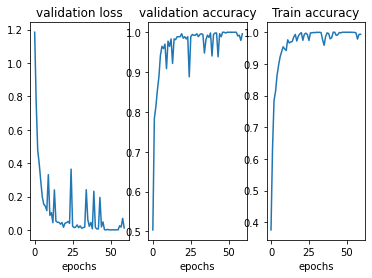

In [ ]:
# history.history
# fig = plt.figure(figsize=(16,4))
fig,ax=plt.subplots(1,3)
# ax = fig.add_subplot(121)
ax[0].plot(history.history["val_loss"])
ax[0].set_title("validation loss")
ax[0].set_xlabel("epochs")

# ax2 = fig.add_subplot(122)
ax[1].plot(history.history["val_accuracy"])
ax[1].set_title("validation accuracy")
# ax[1].set_ylim(0, 1)
ax[1].set_xlabel("epochs")


# ax3 = fig.add_subplot(224)
ax[2].plot(history.history["accuracy"])
ax[2].set_title("Train accuracy")
ax[2].set_xlabel("epochs")
# ax3.set_ylim(0, 1)
plt.rcParams["figure.figsize"] = (16,4)
plt.show()

Notice that the validation loss begins to actually rise after around 16 epochs, even though validation accuracy remains roughly between 40% and 50%. This suggests our model begins overfitting around then, and best performance would have been achieved if we had stopped early around then. Nevertheless, our accuracy would not have likely been above 50%, and probably lower down.

We can also get a final evaluation by running our model on the training set. Doing so, we get the following results:

In [ ]:
loss, accuracy = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', loss)
print('Test accuracy:', accuracy)

Test loss: 0.35414549708366394
Test accuracy: 0.9533582329750061


In [ ]:
row=[["cnn",accuracy,loss,(fin-inicio)/60]]
stats = pd.DataFrame(row,columns=["model","test_accuracy","test_loss","tiempo_ejecucion(min)"])
stats

,model,test_accuracy,test_loss,tiempo_ejecucion(min)
0,cnn,0.953358,0.354145,6.819006


# MobileNet

In [26]:
# import tensorflow as tf

#mobileNet=tf.keras.applications.MobileNetV2(weights='imagenet', include_top=False, input_shape=x_train.shape[1:])
mobileNet=tf.keras.applications.MobileNetV2(weights='imagenet', include_top=False, input_shape=x_train.shape[1:])
mobileNet.trainable = False
print("Number of layers in the base model: ", len(mobileNet.layers))

Number of layers in the base model:  154


In [27]:
x_train.shape[1:]

(224, 224, 3)

In [28]:
from hyperopt import hp, Trials
from sklearn.model_selection import KFold

from kerashypetune import KerasGridSearch, KerasGridSearchCV
from keras import regularizers
opt_mn = tf.keras.optimizers.Adam(learning_rate=1e-4)
from tensorflow.keras.callbacks import *

In [29]:
def get_model(param):
        
    model = Sequential()
    model.add(mobileNet)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(512, activation='relu',kernel_regularizer=regularizers.l1_l2(l1=0.001,l2=0.001)))#,kernel_regularizer=regularizers.l1_l2(l1=0.001,l2=0.001)
    model.add(Dropout(param["dropout"]))
    model.add(Dense(num_classes, activation="softmax",))
    model.compile(loss="categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(learning_rate=param["lr"]),
                    metrics=["accuracy"])
    
    return model

In [30]:
"""
param_grid = {
    'lr': [1e-4],
    'epochs': 60, 
    'batch_size': 128,
    'dropout': [0.35, 0.4,0.45,0.5,0.55],
}
es = EarlyStopping(patience=10, verbose=1, min_delta=0.001, monitor='val_accuracy', mode='auto', restore_best_weights=True)

kgs = KerasGridSearch(get_model, param_grid, monitor='val_loss', greater_is_better=False)
kgs.search(x_train,y_train, validation_data=(x_val, y_val),callbacks=[es])
"""

"\nparam_grid = {\n    'lr': [1e-4],\n    'epochs': 60, \n    'batch_size': 128,\n    'dropout': [0.35, 0.4,0.45,0.5,0.55],\n}\nes = EarlyStopping(patience=10, verbose=1, min_delta=0.001, monitor='val_accuracy', mode='auto', restore_best_weights=True)\n\nkgs = KerasGridSearch(get_model, param_grid, monitor='val_loss', greater_is_better=False)\nkgs.search(x_train,y_train, validation_data=(x_val, y_val),callbacks=[es])\n"

In [31]:
from keras import regularizers
opt_mn = tf.keras.optimizers.Adam(learning_rate=1e-4)

In [32]:
mobileNet_model = Sequential()
mobileNet_model.add(mobileNet)
mobileNet_model.add(GlobalAveragePooling2D())
mobileNet_model.add(Dense(512, activation='relu',kernel_regularizer=regularizers.l1_l2(l1=0.0001,l2=0.0001)))#,kernel_regularizer=regularizers.l1_l2(l1=0.001,l2=0.001)
mobileNet_model.add(Dropout(0.5))
mobileNet_model.add(Dense(num_classes, activation="softmax"))
mobileNet_model.compile(loss="categorical_crossentropy", optimizer=opt_mn,
                    metrics=["accuracy"])
len(mobileNet_model.trainable_variables)

4

In [33]:
print("Number of layers in the base model: ", len(mobileNet.layers))
mobileNet.trainable = True
# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in mobileNet.layers[:fine_tune_at]:
  layer.trainable = False
len(mobileNet_model.trainable_variables)

Number of layers in the base model:  154


58

In [43]:
inicio = time.time()
history4 = mobileNet_model.fit(x_train, y_train, 
                         batch_size=128,#45, 32
                         epochs=60,#10 
                         validation_data=(x_val, y_val))
fin = time.time()
print(fin-inicio)

Epoch 1/60


2022-04-14 16:40:45.670172: W tensorflow/core/common_runtime/bfc_allocator.cc:462] Allocator (GPU_0_bfc) ran out of memory trying to allocate 588.00MiB (rounded to 616562688)requested by op sequential_1/mobilenetv2_1.00_224/block_1_expand/Conv2D
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2022-04-14 16:40:45.670247: I tensorflow/core/common_runtime/bfc_allocator.cc:1010] BFCAllocator dump for GPU_0_bfc
2022-04-14 16:40:45.670261: I tensorflow/core/common_runtime/bfc_allocator.cc:1017] Bin (256): 	Total Chunks: 146, Chunks in use: 144. 36.5KiB allocated for chunks. 36.0KiB in use in bin. 8.2KiB client-requested in use in bin.
2022-04-14 16:40:45.670268: I tensorflow/core/common_runtime/bfc_allocator.cc:1017] Bin (512): 	Total Chunks: 69, Chunks in use: 69. 47.2KiB allocated for chunks. 47.2KiB in use in bin. 39.9KiB client-requ

ResourceExhaustedError: Graph execution error:

Detected at node 'sequential_1/mobilenetv2_1.00_224/block_1_expand/Conv2D' defined at (most recent call last):
    File "/opt/conda/lib/python3.7/runpy.py", line 193, in _run_module_as_main
      "__main__", mod_spec)
    File "/opt/conda/lib/python3.7/runpy.py", line 85, in _run_code
      exec(code, run_globals)
    File "/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py", line 16, in <module>
      app.launch_new_instance()
    File "/opt/conda/lib/python3.7/site-packages/traitlets/config/application.py", line 846, in launch_instance
      app.start()
    File "/opt/conda/lib/python3.7/site-packages/ipykernel/kernelapp.py", line 677, in start
      self.io_loop.start()
    File "/opt/conda/lib/python3.7/site-packages/tornado/platform/asyncio.py", line 199, in start
      self.asyncio_loop.run_forever()
    File "/opt/conda/lib/python3.7/asyncio/base_events.py", line 541, in run_forever
      self._run_once()
    File "/opt/conda/lib/python3.7/asyncio/base_events.py", line 1786, in _run_once
      handle._run()
    File "/opt/conda/lib/python3.7/asyncio/events.py", line 88, in _run
      self._context.run(self._callback, *self._args)
    File "/opt/conda/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 473, in dispatch_queue
      await self.process_one()
    File "/opt/conda/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 462, in process_one
      await dispatch(*args)
    File "/opt/conda/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 369, in dispatch_shell
      await result
    File "/opt/conda/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 664, in execute_request
      reply_content = await reply_content
    File "/opt/conda/lib/python3.7/site-packages/ipykernel/ipkernel.py", line 355, in do_execute
      res = shell.run_cell(code, store_history=store_history, silent=silent)
    File "/opt/conda/lib/python3.7/site-packages/ipykernel/zmqshell.py", line 532, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2958, in run_cell
      raw_cell, store_history, silent, shell_futures)
    File "/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3003, in _run_cell
      return runner(coro)
    File "/opt/conda/lib/python3.7/site-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner
      coro.send(None)
    File "/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3229, in run_cell_async
      interactivity=interactivity, compiler=compiler, result=result)
    File "/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3444, in run_ast_nodes
      if (await self.run_code(code, result,  async_=asy)):
    File "/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3524, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/tmp/ipykernel_18312/491275379.py", line 5, in <module>
      validation_data=(x_val, y_val))
    File "/opt/conda/lib/python3.7/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/opt/conda/lib/python3.7/site-packages/keras/engine/training.py", line 1384, in fit
      tmp_logs = self.train_function(iterator)
    File "/opt/conda/lib/python3.7/site-packages/keras/engine/training.py", line 1021, in train_function
      return step_function(self, iterator)
    File "/opt/conda/lib/python3.7/site-packages/keras/engine/training.py", line 1010, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/opt/conda/lib/python3.7/site-packages/keras/engine/training.py", line 1000, in run_step
      outputs = model.train_step(data)
    File "/opt/conda/lib/python3.7/site-packages/keras/engine/training.py", line 859, in train_step
      y_pred = self(x, training=True)
    File "/opt/conda/lib/python3.7/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/opt/conda/lib/python3.7/site-packages/keras/engine/base_layer.py", line 1096, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/opt/conda/lib/python3.7/site-packages/keras/utils/traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "/opt/conda/lib/python3.7/site-packages/keras/engine/sequential.py", line 374, in call
      return super(Sequential, self).call(inputs, training=training, mask=mask)
    File "/opt/conda/lib/python3.7/site-packages/keras/engine/functional.py", line 452, in call
      inputs, training=training, mask=mask)
    File "/opt/conda/lib/python3.7/site-packages/keras/engine/functional.py", line 589, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "/opt/conda/lib/python3.7/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/opt/conda/lib/python3.7/site-packages/keras/engine/base_layer.py", line 1096, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/opt/conda/lib/python3.7/site-packages/keras/utils/traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "/opt/conda/lib/python3.7/site-packages/keras/engine/functional.py", line 452, in call
      inputs, training=training, mask=mask)
    File "/opt/conda/lib/python3.7/site-packages/keras/engine/functional.py", line 589, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "/opt/conda/lib/python3.7/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/opt/conda/lib/python3.7/site-packages/keras/engine/base_layer.py", line 1096, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/opt/conda/lib/python3.7/site-packages/keras/utils/traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "/opt/conda/lib/python3.7/site-packages/keras/layers/convolutional.py", line 248, in call
      outputs = self.convolution_op(inputs, self.kernel)
    File "/opt/conda/lib/python3.7/site-packages/keras/layers/convolutional.py", line 240, in convolution_op
      name=self.__class__.__name__)
Node: 'sequential_1/mobilenetv2_1.00_224/block_1_expand/Conv2D'
OOM when allocating tensor with shape[128,96,112,112] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node sequential_1/mobilenetv2_1.00_224/block_1_expand/Conv2D}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_627689]

(0.0, 1.0)

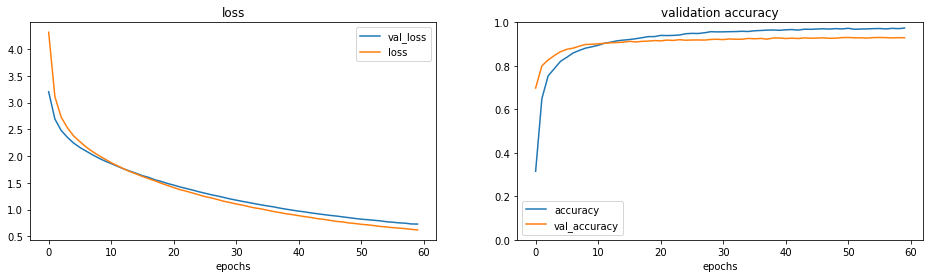

In [35]:
fig = plt.figure(figsize=(16,4))
ax = fig.add_subplot(121)
ax.plot(history4.history["val_loss"])
# ax.plot(history2.history["val_loss"])
# ax.plot(history3.history["val_loss"])
ax.plot(history4.history["loss"])
ax.set_title("loss")
ax.set_xlabel("epochs")
plt.legend(['val_loss','loss'])

ax2 = fig.add_subplot(122)
ax2.plot(history4.history["accuracy"])
# ax2.plot(history2.history["val_accuracy"])
# ax2.plot(history3.history["val_accuracy"])
ax2.plot(history4.history["val_accuracy"])
ax2.set_title("validation accuracy")
ax2.set_xlabel("epochs")
plt.legend(['accuracy','val_accuracy'])
ax2.set_ylim(0, 1)

In [39]:
loss, accuracy= mobileNet_model.evaluate(x_test, y_test, verbose=0)

print('Test loss:', loss)
print('Test accuracy:', accuracy)

Test loss: 0.887486457824707
Test accuracy: 0.880398690700531


<AxesSubplot:>

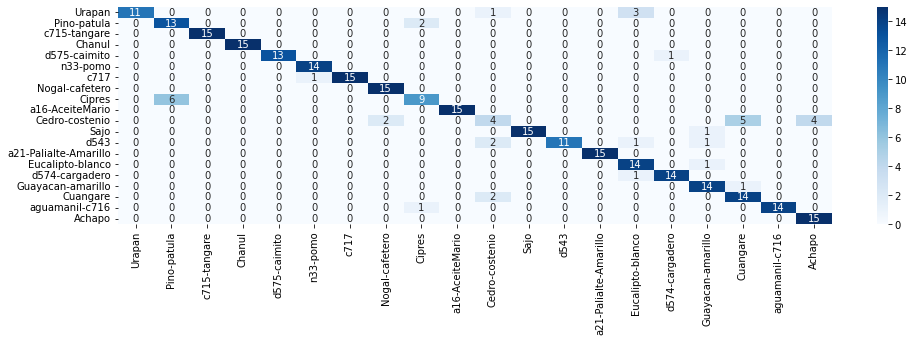

In [40]:
probabilities = mobileNet_model.predict(x_test)
fig = plt.figure(figsize=(16,4))
cm=confusion_matrix(y_test.argmax(axis=1),probabilities.argmax(axis=1))
sns.heatmap(cm, annot=True,xticklabels=labels,yticklabels=labels,cmap='Blues')

In [45]:
img, x = get_image('muestras/test/Cipres/Wed Oct 02 16-08-31.jpg')
x=x.astype('float32') / 255.
probabilities_x = mobileNet_model.predict([x])
df = pd.DataFrame(probabilities_x,columns=labels)
df

,Urapan,Pino-patula,c715-tangare,Chanul,d575-caimito,n33-pomo,c717,Nogal-cafetero,Cipres,a16-AceiteMario,Cedro-costenio,Sajo,d543,a21-Palialte-Amarillo,Eucalipto-blanco,d574-cargadero,Guayacan-amarillo,Cuangare,aguamanil-c716,Achapo
0,0.000004,0.015102,3.363616e-08,0.000001,0.000007,9.881806e-08,5.938358e-07,1.843796e-07,0.98473,2.114316e-07,8.210548e-07,0.000106,2.254372e-07,5.463326e-07,0.000013,0.000001,0.000013,0.00001,0.00001,0.000001


In [74]:
row=[["MobileNet",accuracy,loss,(fin-inicio)/60]]
stats = pd.DataFrame(row,columns=["model","test_accuracy","test_loss","tiempo_ejecucion(min)"])
stats

,model,test_accuracy,test_loss,tiempo_ejecucion(min)
0,MobileNet,0.870432,0.766053,12.770576


In [42]:
mobileNet_model.save("model_mobilenet_14042022.h5")

# Vgg16

In [ ]:
# import tensorflow as tf
vgg = tf.keras.applications.VGG16(weights='imagenet', include_top=True)
vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
# make a reference to VGG's input layer
inp = vgg.input

# make a new softmax layer with num_classes neurons
new_classification_layer = Dense(num_classes, activation='softmax')

# connect our new layer to the second to last layer in VGG, and make a reference to it
out = new_classification_layer(vgg.layers[-2].output)

# create a new network between inp and out
model_new = Model(inp, out)


In [ ]:
# make all layers untrainable by freezing weights (except for last layer)
for l, layer in enumerate(model_new.layers[:-1]):
    layer.trainable = False

# ensure the last layer is trainable/not frozen
for l, layer in enumerate(model_new.layers[-1:]):
    layer.trainable = True

model_new.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model_new.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
inicio = time.time()
history2 = model_new.fit(x_train, y_train, 
                         batch_size=125,#45, 32
                         epochs=60,#10 
                         validation_data=(x_val, y_val))
fin = time.time()
print(fin-inicio)

Epoch 1/60
20/20 [==============================] - 45s 2s/step - loss: 1.9882 - accuracy: 0.3468 - val_loss: 1.2621 - val_accuracy: 0.6716
Epoch 2/60
20/20 [==============================] - 27s 1s/step - loss: 1.0120 - accuracy: 0.8208 - val_loss: 0.7352 - val_accuracy: 0.8993
Epoch 3/60
20/20 [==============================] - 27s 1s/step - loss: 0.6255 - accuracy: 0.9184 - val_loss: 0.4978 - val_accuracy: 0.9310
Epoch 4/60
20/20 [==============================] - 27s 1s/step - loss: 0.4565 - accuracy: 0.9284 - val_loss: 0.3940 - val_accuracy: 0.9384
Epoch 5/60
20/20 [==============================] - 27s 1s/step - loss: 0.3690 - accuracy: 0.9484 - val_loss: 0.3249 - val_accuracy: 0.9459
Epoch 6/60
20/20 [==============================] - 27s 1s/step - loss: 0.3224 - accuracy: 0.9420 - val_loss: 0.2886 - val_accuracy: 0.9515
Epoch 7/60
20/20 [==============================] - 27s 1s/step - loss: 0.2674 - accuracy: 0.9532 - val_loss: 0.2293 - val_accuracy: 0.9646
Epoch 8/60
20/20 [==

Our validation accuracy hovers close to 80% towards the end, which is more than 30% improvement on the original network trained from scratch (meaning that we make the wrong prediction on 20% of samples, rather than 50%). 

It's worth noting also that this network actually trains _slightly faster_ than the original network, despite having more than 100 times as many parameters! This is because freezing the weights negates the need to backpropagate through all those layers, saving us on runtime.

Let's plot the validation loss and accuracy again, this time comparing the original model trained from scratch (in blue) and the new transfer-learned model in green.

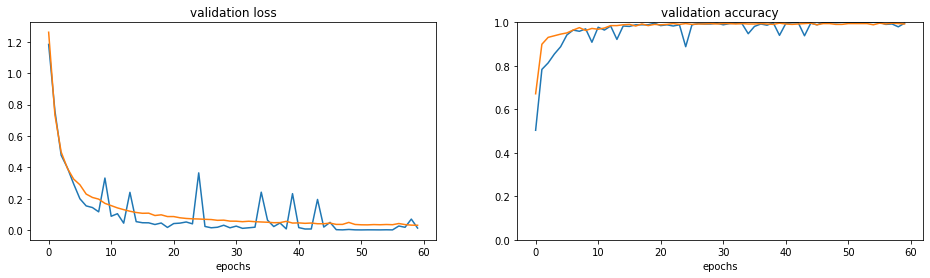

In [ ]:
fig = plt.figure(figsize=(16,4))
ax = fig.add_subplot(121)
ax.plot(history.history["val_loss"])
ax.plot(history2.history["val_loss"])
ax.set_title("validation loss")
ax.set_xlabel("epochs")

ax2 = fig.add_subplot(122)
ax2.plot(history.history["val_accuracy"])
ax2.plot(history2.history["val_accuracy"])
ax2.set_title("validation accuracy")
ax2.set_xlabel("epochs")
ax2.set_ylim(0, 1)

plt.show()

Notice that whereas the original model began overfitting around epoch 16, the new model continued to slowly decrease its loss over time, and likely would have improved its accuracy slightly with more iterations. The new model made it to roughly 80% top-1 accuracy (in the validation set) and continued to improve slowly through 100 epochs.

It's possibly we could have improved the original model with better regularization or more dropout, but we surely would not have made up the >30% improvement in accuracy. 

Again, we do a final validation on the test set.

In [ ]:
loss, accuracy= model_new.evaluate(x_test, y_test, verbose=0)

print('Test loss:', loss)
print('Test accuracy:', accuracy)
# print("test recall",recall)
# print('test precision',Precision)

Test loss: 0.11044074594974518
Test accuracy: 0.9701492786407471


In [ ]:
row=["VGG16",accuracy,loss,(fin-inicio)/60]
stats.loc[2]= row
stats

,model,test_accuracy,test_loss,tiempo_ejecucion(min)
0,cnn,0.953358,0.354145,6.819006
1,MobileNet,0.981343,0.141224,9.447245
2,VGG16,0.970149,0.110441,19.437158


To predict a new image, simply run the following code to get the probabilities for each class.

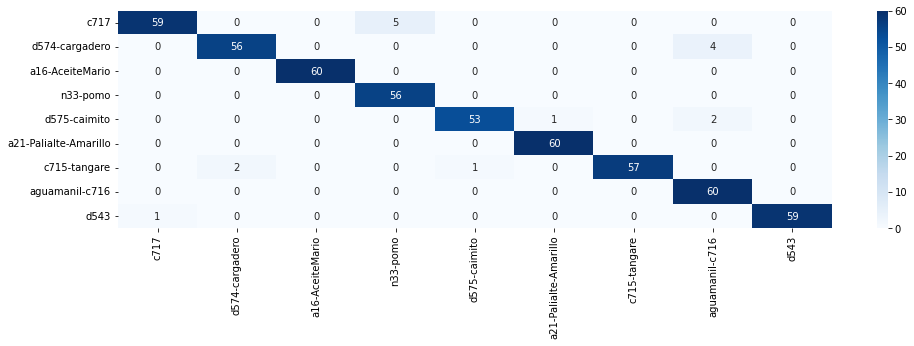

In [ ]:
# img, x = get_image('3.jpg')
# print(x_test)
probabilities = model_new.predict(x_test)
df = pd.DataFrame(probabilities,columns=categories)
#df
cm=confusion_matrix(y_test.argmax(axis=1),probabilities.argmax(axis=1))

sns.heatmap(cm, annot=True,xticklabels=labels,yticklabels=labels,cmap='Blues')

In [ ]:
img, x = get_image('/content/SingleShot0100.jpg')
x=x.astype('float32') / 255.
probabilities_x = model_new.predict([x])
df = pd.DataFrame(probabilities_x,columns=labels)
df

,c717,d574-cargadero,a16-AceiteMario,n33-pomo,d575-caimito,a21-Palialte-Amarillo,c715-tangare,aguamanil-c716,d543
0,0.000189,0.000052,0.000376,0.000608,7.908820e-08,0.000042,0.998711,3.796737e-07,0.000023


In [ ]:
def predict(model_keras):
  probabilities = model_keras.predict(x_test)
  df = pd.DataFrame(probabilities,columns=labels)
  return df

# ResNet 50

In [50]:
from keras import regularizers
opt_rn = tf.keras.optimizers.Adam(learning_rate=1e-4)

In [51]:
pretrained_model= tf.keras.applications.ResNet50V2(input_shape=x_train.shape[1:], weights='imagenet',include_top=False)
pretrained_model.trainable = False
print("Number of layers in the base model: ", len(pretrained_model.layers))

Number of layers in the base model:  190


In [52]:
resnet_model = Sequential()
resnet_model.add(pretrained_model)
resnet_model.add(GlobalAveragePooling2D())
# resnet_model.add(Flatten())
resnet_model.add(Dense(512, activation='relu',kernel_regularizer=regularizers.l1_l2(l1=0.0001,l2=0.0001)))
resnet_model.add(Dropout(0.5))
resnet_model.add(Dense(num_classes, activation='softmax'))
resnet_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 global_average_pooling2d_2   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_4 (Dense)             (None, 512)               1049088   
                                                                 
 dropout_2 (Dropout)         (None, 512)               0         
                                                                 
 dense_5 (Dense)             (None, 20)                10260     
                                                                 
Total params: 24,624,148
Trainable params: 1,059,348
Non-trainable params: 23,564,800
__________________________________

In [53]:
lr=random.choice((1e-2, 1e-3, 1e-4, 1e-5))
resnet_model.compile(loss='categorical_crossentropy',
                     optimizer=opt_rn,
              # optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              # optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
              metrics=['accuracy'],)
lr,len(resnet_model.trainable_variables)


(0.0001, 4)

In [54]:
print("Number of layers in the base model: ", len(pretrained_model.layers))
pretrained_model.trainable = True
# Fine-tune from this layer onwards
fine_tune_at = 130

# Freeze all the layers before the `fine_tune_at` layer
for layer in pretrained_model.layers[:fine_tune_at]:
  layer.trainable = False
len(resnet_model.trainable_variables)

Number of layers in the base model:  190


58

In [ ]:
inicio = time.time()
history2 = resnet_model.fit(x_train, y_train, 
                         batch_size=128,#45, 32
                         epochs=60,#10 
                         validation_data=(x_val, y_val))
fin = time.time()
print(fin-inicio)

In [ ]:
fig = plt.figure(figsize=(16,4))
ax = fig.add_subplot(121)
ax.plot(history2.history["loss"])
ax.plot(history2.history["val_loss"])
ax.set_title("loss")
plt.legend(['loss', 'val_loss'])
ax.set_xlabel("epochs")

ax2 = fig.add_subplot(122)
ax2.plot(history2.history["accuracy"])
ax2.plot(history2.history["val_accuracy"])
ax2.set_title("validation accuracy")
ax2.set_xlabel("epochs")
plt.legend(['acc', 'val_acc'])
ax2.set_ylim(0, 1)

In [53]:
loss, accuracy= resnet_model.evaluate(x_test, y_test, verbose=0)

print('Test loss:', loss)
print('Test accuracy:', accuracy)

Test loss: 0.58864825963974
Test accuracy: 0.920265793800354


In [83]:
row=["ResNet50",accuracy,loss,(fin-inicio)/60]
stats.loc[1]= row
stats

,model,test_accuracy,test_loss,tiempo_ejecucion(min)
0,MobileNet,0.870432,0.766053,12.770576
1,ResNet50,0.897010,0.607746,31.271414


<AxesSubplot:>

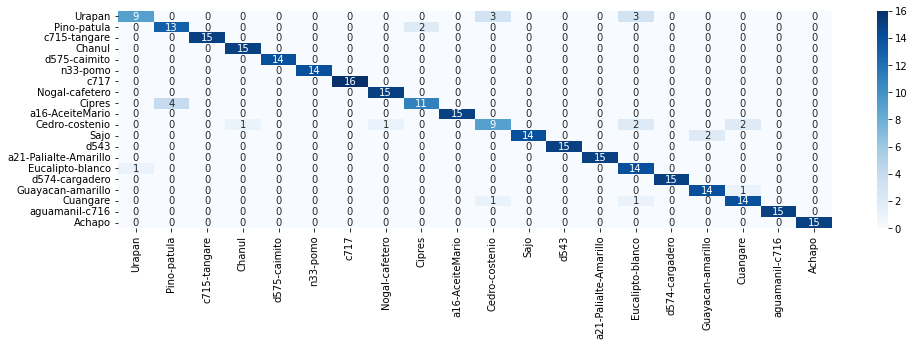

In [62]:
# img, x = get_image('3.jpg')
# print(x_test)
probabilities = resnet_model.predict(x_test)
fig = plt.figure(figsize=(16,4))
#df
cm=confusion_matrix(y_test.argmax(axis=1),probabilities.argmax(axis=1))

sns.heatmap(cm, annot=True,xticklabels=labels,yticklabels=labels,cmap='Blues')

In [ ]:
# df =  predict(resnet_model)
# df.loc[1]

In [60]:
img, x = get_image('muestras/test/Cipres/Wed Oct 02 16-08-07.jpg')
x=x.astype('float32') / 255.
probabilities_x = resnet_model.predict([x])
df = pd.DataFrame(probabilities_x,columns=labels)
df

,Urapan,Pino-patula,c715-tangare,Chanul,d575-caimito,n33-pomo,c717,Nogal-cafetero,Cipres,a16-AceiteMario,Cedro-costenio,Sajo,d543,a21-Palialte-Amarillo,Eucalipto-blanco,d574-cargadero,Guayacan-amarillo,Cuangare,aguamanil-c716,Achapo
0,0.000004,0.437447,0.000005,0.000008,0.000274,0.000002,0.000029,0.000006,0.560368,0.00004,0.000245,0.000009,0.000005,0.000004,0.000841,0.000155,0.000012,0.000245,0.000101,0.000198


In [ ]:
# resnet_model.save("model_resnet_06022022.h5")
# model_new.save_weights('weights_resnet')

# EfficientNet


In [ ]:
base_model =  tf.keras.applications.efficientnet.EfficientNetB0(weights = 'imagenet', include_top = False, input_shape=x_train.shape[1:])
# Adding a global spatial average pooling layer
base_model.trainable = False
# x = base_model.output
# x = GlobalAveragePooling2D()(x)

# #Adding a fully-connected dense layer
# x = Dense(512, activation='relu')(x)
# predictions = Dense(num_classes, activation="softmax")(x)#.layers[-2].output
# efn_model = Model(inputs = base_model.input, outputs = predictions)
# # efn_model.summary()
# len(efn_model.trainable_variables)

16719872/16705208 [==============================] - 0s 0us/step


In [ ]:
efficientNet_model = Sequential()
efficientNet_model.add(base_model)
efficientNet_model.add(GlobalAveragePooling2D())
efficientNet_model.add(Dense(512, activation='relu'))
efficientNet_model.add(Dense(num_classes, activation="softmax"))
efficientNet_model.compile(loss="categorical_crossentropy", optimizer="adam",
                    metrics=["accuracy"])
len(efficientNet_model.trainable_variables)

4

In [ ]:
lr=random.choice((1e-2, 1e-3, 1e-4, 1e-5))
efficientNet_model.compile(loss="categorical_crossentropy", optimizer="adam",
                    metrics=["accuracy"])
lr

0.001

In [ ]:
print("Number of layers in the base model: ", len(base_model.layers))
base_model.trainable = True
# Fine-tune from this layer onwards
fine_tune_at = 177

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False
len(efficientNet_model.trainable_variables)

Number of layers in the base model:  237


58

In [ ]:
inicio = time.time()
history3 = efficientNet_model.fit(x_train, y_train, 
                         batch_size=32,#45, 32
                         epochs=60,#10 
                         validation_data=(x_val, y_val))
fin = time.time()
print(fin-inicio)

Epoch 1/60
79/79 [==============================] - 25s 203ms/step - loss: 2.2156 - accuracy: 0.1008 - val_loss: 2.2031 - val_accuracy: 0.1007
Epoch 2/60
79/79 [==============================] - 13s 163ms/step - loss: 2.1992 - accuracy: 0.1112 - val_loss: 2.2006 - val_accuracy: 0.0616
Epoch 3/60
79/79 [==============================] - 12s 157ms/step - loss: 2.1990 - accuracy: 0.1004 - val_loss: 2.1989 - val_accuracy: 0.1157
Epoch 4/60
79/79 [==============================] - 12s 157ms/step - loss: 2.1972 - accuracy: 0.1112 - val_loss: 2.1968 - val_accuracy: 0.0951
Epoch 5/60
47/79 [================>.............] - ETA: 4s - loss: 2.1969 - accuracy: 0.1090

KeyboardInterrupt: ignored

(0.0, 1.0)

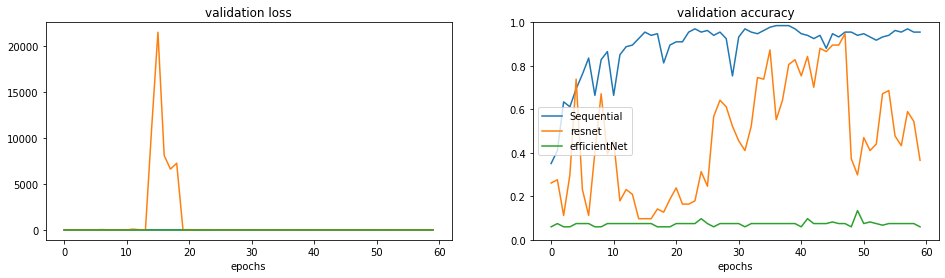

In [ ]:
fig = plt.figure(figsize=(16,4))
ax = fig.add_subplot(121)
ax.plot(history.history["val_loss"])
ax.plot(history2.history["val_loss"])
ax.plot(history3.history["val_loss"])
ax.set_title("validation loss")
ax.set_xlabel("epochs")

ax2 = fig.add_subplot(122)
ax2.plot(history.history["val_accuracy"])
ax2.plot(history2.history["val_accuracy"])
ax2.plot(history3.history["val_accuracy"])
ax2.set_title("validation accuracy")
ax2.set_xlabel("epochs")
plt.legend(['Sequential', 'resnet',"efficientNet"])
ax2.set_ylim(0, 1)

In [ ]:
loss, accuracy= efficientNet_model.evaluate(x_test, y_test, verbose=0)

print('Test loss:', loss)
print('Test accuracy:', accuracy)

Test loss: 28.45322608947754
Test accuracy: 0.11194030195474625
